In [35]:
import torch
import numpy as np
import pyquaternion
import glm
import os
import math
import matplotlib.pyplot as plt
import diff_gaussian_rasterization_batched as dgrb

In [36]:
device = torch.device("cuda")

# generate a random point cloud
C = 4
B = 1
N = 100
means3D = torch.cat(
    [
        torch.rand(B, N, 1, dtype=torch.float32, device=device) * 2 - 1,
        torch.rand(B, N, 1, dtype=torch.float32, device=device) * 2 - 1,
        torch.rand(B, N, 1, dtype=torch.float32, device=device) * 2 - 1,
    ],
    dim=2,
)
means2D = torch.zeros(B, N, 2, dtype=torch.float32, device=device)
opacities = torch.ones(B, N, 1, dtype=torch.float32, device=device)
scales = torch.ones(B, N, 3, dtype=torch.float32, device=device) * 0.1
rotations = (
    torch.from_numpy(np.stack([pyquaternion.Quaternion().elements for _ in range(N)]))
    .to(torch.float32)
    .to(device)
    .expand(B, N, 4)
)
colors_precomp = torch.rand(B, N, C, dtype=torch.float32, device=device)

In [37]:
def toTensor(m: glm.mat4) -> torch.Tensor:
    return torch.tensor(m.to_list(), dtype=torch.float32, device=device)

In [38]:
def random_point_on_sphere(r:float) -> list[float]:
    phi = torch.rand(1).item() * 2 * math.pi
    theta = torch.rand(1).item() * math.pi
    return [
            r * math.sin(theta) * math.cos(phi),
            r * math.sin(theta) * math.sin(phi),
            r * math.cos(theta),
    ]


[-1.0440651618375678, -0.6776784163317195, 2.7295933583365906]


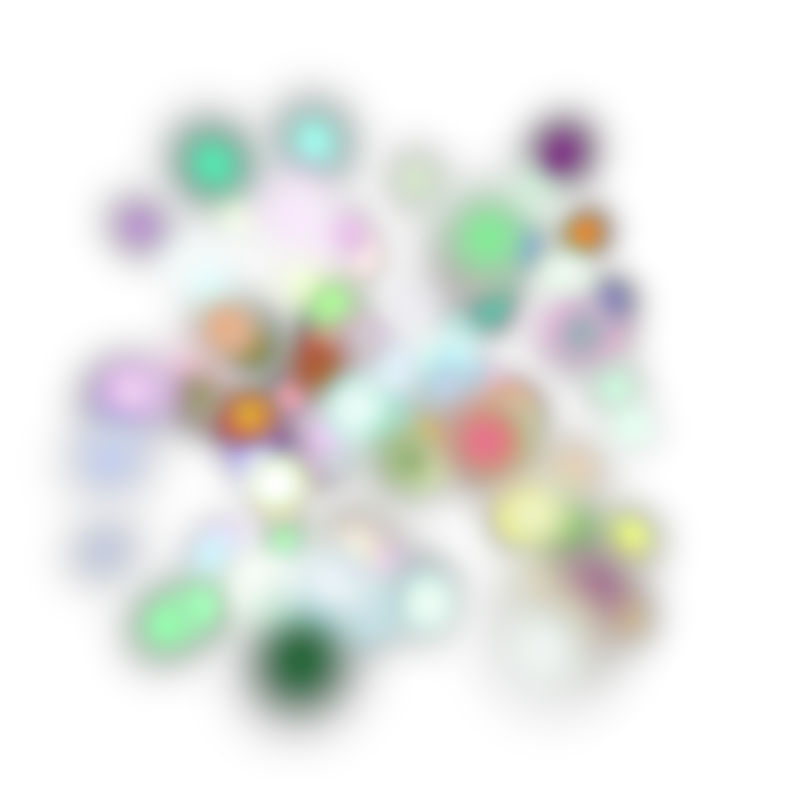

In [39]:
FoVx = math.radians(60)
FoVy = math.radians(60)


eye = random_point_on_sphere(3)
print(eye)


rasterizer = dgrb.GaussianRasterizer(
    dgrb.GaussianRasterizationSettings(
        image_channels=C,
        image_height=512,
        image_width=512,
        tanfovx=math.tan(FoVx * 0.5),
        tanfovy=math.tan(FoVy * 0.5),
        bg=torch.zeros(C, dtype=torch.float32, device=device),
        scale_modifier=1.0,
        viewmatrix=toTensor(
            glm.scale([1, 1, -1])
            * glm.lookAt(eye, [0, 0, 0], [0, 1, 0])
        ),
        projmatrix=toTensor(glm.perspective(FoVy, 1, 0.2, 100)),
        sh_degree=1,
        campos=torch.tensor([0, 0, 0], dtype=torch.float32, device=device),
        prefiltered=False,
        debug=True,
    )
)

rendered_image, radii = rasterizer(
    means3D=means3D,
    means2D=means2D,
    colors_precomp=colors_precomp,
    opacities=opacities,
    scales=scales,
    rotations=rotations,
)

# display the rendered image
image_batch = rendered_image.permute(0, 2, 3, 1).cpu().numpy()
batches = image_batch.shape[0]
fig, ax = plt.subplots(batches, 1, figsize=(10, 10), squeeze=False)
for i in range(batches):
    ax[i, 0].imshow(image_batch[i])
    ax[i, 0].axis("off")

In [40]:
means3D_homog = torch.cat([means3D, torch.ones(B, N, 1, dtype=torch.float32, device=device)], dim=2).squeeze(0)


view3D =  means3D_homog @ toTensor(glm.lookAt([0, 0, 0], [-2, 0, -2], [0, -1, 0])).T 
view3D_norm = view3D / view3D[:, 3].unsqueeze(1)

view3D_norm

tensor([[ 5.0080e-01, -5.0240e-01,  6.2435e-01,  1.0000e+00],
        [ 7.2373e-01,  9.8448e-01,  6.1556e-01,  1.0000e+00],
        [ 2.7690e-01,  1.4777e-01,  2.7628e-01,  1.0000e+00],
        [ 2.0310e-01, -1.4492e-01,  7.8936e-01,  1.0000e+00],
        [-8.1011e-01,  9.3673e-01,  1.0103e-01,  1.0000e+00],
        [-4.6910e-01, -2.6544e-01, -6.5871e-01,  1.0000e+00],
        [-8.4084e-01,  6.2924e-01,  5.4740e-01,  1.0000e+00],
        [-9.3950e-01,  6.5420e-01,  2.3581e-01,  1.0000e+00],
        [ 7.0181e-01, -9.1837e-01, -4.4072e-01,  1.0000e+00],
        [ 8.3523e-01, -8.6944e-02, -3.6869e-01,  1.0000e+00],
        [ 1.3497e-01, -9.3773e-01, -1.0261e+00,  1.0000e+00],
        [-6.5145e-01,  7.7233e-01, -1.9004e-01,  1.0000e+00],
        [-2.0046e-02,  8.4312e-01,  4.7710e-01,  1.0000e+00],
        [ 2.3295e-04, -4.3623e-01, -1.2284e+00,  1.0000e+00],
        [-1.5120e-01,  5.8130e-02,  8.5142e-01,  1.0000e+00],
        [-1.3536e-01, -6.5572e-01,  1.1210e+00,  1.0000e+00],
        